<a href="https://colab.research.google.com/github/Harsha-Musunuri/CNN-MusicGenreClassification/blob/master/deepMusicNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music genre classification notebook

## Importing Libraries

In [0]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Tensorflow
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting music and features

### Dataset

We use [GTZAN genre collection](http://marsyasweb.appspot.com/download/data_sets/) dataset for classification. 
<br>
<br>
The dataset consists of 10 genres i.e
 * Blues
 * Classical
 * Country
 * Disco
 * Hiphop
 * Jazz
 * Metal
 * Pop
 * Reggae
 * Rock
 
Each genre contains 100 songs. Total dataset: 1000 songs

## Extracting the Spectrogram for every Audio

KeyboardInterrupt: ignored

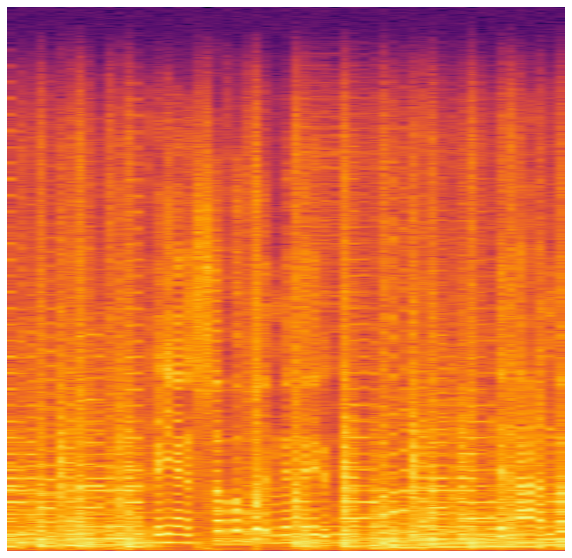

In [4]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'/content/drive/My Drive/datasets/img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'/content/drive/My Drive/datasets/genres/{g}'):
        songname = f'/content/drive/My Drive/datasets/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'/content/drive/My Drive/datasets/img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
 

All the audio files get converted into their respective spectrograms .WE can noe easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [0]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file 

In [0]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/content/drive/My Drive/datasets/genres/{g}'):
        songname = f'/content/drive/My Drive/datasets/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

The data has been extracted into a [data.csv](https://github.com/parulnith/Music-Genre-Classification-with-Python/blob/master/data.csv) file.

# Analysing the Data in Pandas

In [5]:
data = pd.read_csv('/content/drive/My Drive/datasets/deepAudioClassification.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00093.wav,0.377690,0.065906,569.930721,995.407125,927.427725,0.021701,-350.436188,169.545746,31.820370,16.682835,28.710146,19.256973,7.863395,10.036764,4.735106,2.907466,3.915553,1.821690,-5.970891,-5.259567,-0.229211,-1.776850,-3.713751,0.181591,2.072390,-2.896225,blues
1,blues.00087.wav,0.336773,0.158098,1442.190271,1870.534155,3083.414688,0.050889,-155.504929,125.638863,1.596553,45.804523,0.900778,25.367563,-10.787497,15.566381,-11.920467,1.264441,-6.649821,-0.792893,-7.748057,0.413548,-7.030263,3.997679,-6.256611,0.958227,2.019821,-5.742188,blues
2,blues.00050.wav,0.400860,0.182380,1945.848425,2082.246626,4175.874749,0.085806,-82.979019,107.052124,-25.320452,57.124992,0.085439,34.696800,-11.042020,20.532696,-11.213177,14.834125,-10.229334,12.539581,-9.762303,2.562253,-6.300853,2.996785,-8.718455,-0.326581,-2.980347,0.712600,blues
3,blues.00044.wav,0.390212,0.136276,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922409,-8.607986,64.494560,-6.304128,43.639511,-8.286754,28.546106,-14.079794,8.125041,-21.491404,11.087481,-5.085794,3.976360,-12.859742,12.343859,0.026216,-0.741568,-5.126620,3.303442,blues
4,blues.00078.wav,0.414188,0.258052,2333.685108,2227.425609,4942.811778,0.123863,-2.524338,101.252716,-33.924385,41.516891,-13.804996,31.919870,-21.864820,24.458441,-15.880980,15.789354,-14.366657,12.506608,-13.368823,6.112817,-9.065890,5.033774,-11.330276,3.166534,-4.567591,-4.033623,blues


In [6]:
data.shape

(1000, 28)

In [0]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [8]:
data.head(5)

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.377690,0.065906,569.930721,995.407125,927.427725,0.021701,-350.436188,169.545746,31.820370,16.682835,28.710146,19.256973,7.863395,10.036764,4.735106,2.907466,3.915553,1.821690,-5.970891,-5.259567,-0.229211,-1.776850,-3.713751,0.181591,2.072390,-2.896225,blues
1,0.336773,0.158098,1442.190271,1870.534155,3083.414688,0.050889,-155.504929,125.638863,1.596553,45.804523,0.900778,25.367563,-10.787497,15.566381,-11.920467,1.264441,-6.649821,-0.792893,-7.748057,0.413548,-7.030263,3.997679,-6.256611,0.958227,2.019821,-5.742188,blues
2,0.400860,0.182380,1945.848425,2082.246626,4175.874749,0.085806,-82.979019,107.052124,-25.320452,57.124992,0.085439,34.696800,-11.042020,20.532696,-11.213177,14.834125,-10.229334,12.539581,-9.762303,2.562253,-6.300853,2.996785,-8.718455,-0.326581,-2.980347,0.712600,blues
3,0.390212,0.136276,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922409,-8.607986,64.494560,-6.304128,43.639511,-8.286754,28.546106,-14.079794,8.125041,-21.491404,11.087481,-5.085794,3.976360,-12.859742,12.343859,0.026216,-0.741568,-5.126620,3.303442,blues
4,0.414188,0.258052,2333.685108,2227.425609,4942.811778,0.123863,-2.524338,101.252716,-33.924385,41.516891,-13.804996,31.919870,-21.864820,24.458441,-15.880980,15.789354,-14.366657,12.506608,-13.368823,6.112817,-9.065890,5.033774,-11.330276,3.166534,-4.567591,-4.033623,blues


In [9]:
data.iloc[:, :-2]

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
0,0.377690,0.065906,569.930721,995.407125,927.427725,0.021701,-350.436188,169.545746,31.820370,16.682835,28.710146,19.256973,7.863395,10.036764,4.735106,2.907466,3.915553,1.821690,-5.970891,-5.259567,-0.229211,-1.776850,-3.713751,0.181591,2.072390
1,0.336773,0.158098,1442.190271,1870.534155,3083.414688,0.050889,-155.504929,125.638863,1.596553,45.804523,0.900778,25.367563,-10.787497,15.566381,-11.920467,1.264441,-6.649821,-0.792893,-7.748057,0.413548,-7.030263,3.997679,-6.256611,0.958227,2.019821
2,0.400860,0.182380,1945.848425,2082.246626,4175.874749,0.085806,-82.979019,107.052124,-25.320452,57.124992,0.085439,34.696800,-11.042020,20.532696,-11.213177,14.834125,-10.229334,12.539581,-9.762303,2.562253,-6.300853,2.996785,-8.718455,-0.326581,-2.980347
3,0.390212,0.136276,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922409,-8.607986,64.494560,-6.304128,43.639511,-8.286754,28.546106,-14.079794,8.125041,-21.491404,11.087481,-5.085794,3.976360,-12.859742,12.343859,0.026216,-0.741568,-5.126620
4,0.414188,0.258052,2333.685108,2227.425609,4942.811778,0.123863,-2.524338,101.252716,-33.924385,41.516891,-13.804996,31.919870,-21.864820,24.458441,-15.880980,15.789354,-14.366657,12.506608,-13.368823,6.112817,-9.065890,5.033774,-11.330276,3.166534,-4.567591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.457221,0.124174,1867.235838,2422.256647,4270.982507,0.056988,-123.998863,109.507980,5.886388,32.896305,10.973795,11.686162,12.677259,12.976705,1.649139,4.498659,9.673376,3.063167,3.533335,0.729908,1.764981,-0.678046,-0.033834,-1.010613,-5.570284
996,0.392898,0.161538,2157.822776,2060.259516,4244.324335,0.121604,-55.298634,114.435890,-34.063801,37.979469,-22.325554,18.520617,-18.151169,13.802691,-27.798647,18.156794,-14.618975,6.550629,-8.267242,-2.256248,-11.608406,2.496105,-10.946154,0.705372,-0.678453
997,0.398055,0.152507,2188.376105,2120.348371,4433.073194,0.117590,-56.912151,115.195763,-30.433733,37.195583,-21.980320,21.864517,-19.757450,14.993086,-24.064768,17.783127,-17.268303,6.744224,-10.743413,0.814011,-10.161298,3.680640,-8.554656,-0.911824,-2.523441
998,0.421082,0.191175,2789.712144,2648.716877,5836.164710,0.135008,-28.061827,65.631660,-7.352339,33.593666,11.072847,14.760890,2.197583,10.065200,-0.329750,10.135974,-2.750565,3.189335,-1.685570,-0.161785,-1.691114,1.850430,-3.969524,-1.626861,-6.389011


## Encoding the Labels

In [0]:
genre_list = data.iloc[:, -1] #all rows last column only
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

# iloc explanation:
# df.iloc[:3] # slice your object, i.e. first three rows of your dataframe
# df.iloc[0:3] # same
# df.iloc[0, 1] # index both axis. Select the element from the first row, second column.
# df.iloc[:, 0:5] # first five columns of data frame with all rows
# data.iloc[:, -2:] #last two columns only
# data.iloc[:, :-2] #all columns except the last 2 columns

## Scaling the Feature columns

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) #select all columns except the last column

## Dividing data into training and Testing set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
len(y_train)

800

In [14]:
len(y_test)

200

In [15]:
X_train[10]

array([-1.97574287, -1.45903489,  0.309611  , -0.6802452 , -0.1747657 ,
        1.50786508, -1.57141488, -1.34189799, -2.31554685, -0.16374177,
       -1.61571091,  0.26260364,  0.45147374,  3.71924079,  3.15517406,
        2.43964067, -1.70547137, -0.70680254,  0.16989507,  3.27145354,
        2.83870081,  2.28565615,  3.35212024,  3.84571103, -1.35393649,
       -1.24071719])

In [16]:
X_train.shape[1]

26

# Classification with Keras

## Building our Network

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               6912      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 48,714
Trainable params: 48,714
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split = 0.2
                    )
                   

Epoch 1/20
5/5 [==============================] - 0s 36ms/step - loss: 2.1570 - accuracy: 0.2656 - val_loss: 2.0249 - val_accuracy: 0.2625
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 1.8583 - accuracy: 0.3672 - val_loss: 1.8547 - val_accuracy: 0.3125
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 1.6566 - accuracy: 0.4078 - val_loss: 1.7255 - val_accuracy: 0.3313
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 1.4939 - accuracy: 0.4516 - val_loss: 1.6204 - val_accuracy: 0.3625
Epoch 5/20
5/5 [==============================] - 0s 30ms/step - loss: 1.3592 - accuracy: 0.5156 - val_loss: 1.5392 - val_accuracy: 0.4500
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 1.2458 - accuracy: 0.5859 - val_loss: 1.5139 - val_accuracy: 0.4563
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 1.1456 - accuracy: 0.6156 - val_loss: 1.4530 - val_accuracy: 0.4688
Epoch 8/20
5/5 [================

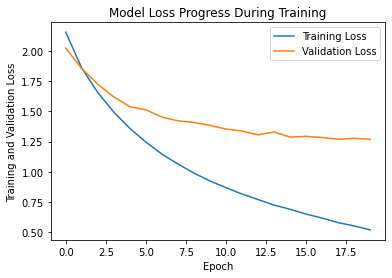

In [20]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('Model Loss Progress During Training')

plt.xlabel('Epoch')

plt.ylabel('Training and Validation Loss')

plt.legend(['Training Loss', 'Validation Loss'])

In [21]:
test_loss, test_acc = model.evaluate(X_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.1875 - accuracy: 0.6400


In [22]:
print('test_acc: ',test_acc)

test_acc:  0.6399999856948853


Tes accuracy is less than training dataa accuracy. This hints at Overfitting

## Validating our approach
Let's set apart 200 samples in our training data to use as a validation set:

In [0]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

Now let's train our network for 20 epochs:

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               13824     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 186,954
Trainable params: 186,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 0s 58ms/step - loss: 2.2905 - accuracy: 0.1217 - val_loss: 2.130

In [25]:
results

[1.1972477436065674, 0.625]

## Predictions on Test Data

In [0]:
import random

In [0]:
X_Sample_test=X_test[random.randint(0, 199)]

In [0]:
X_Sample_test_reshaped=X_Sample_test.reshape(1,26)

In [82]:
X_Sample_test_reshaped

array([[ 0.98073806, -0.30745095, -0.38040515,  0.01269394, -0.10196249,
        -1.18254387, -0.25390974, -0.0478904 , -0.11069986,  0.11840725,
         0.50850024,  0.90971521, -0.67452298,  1.43386609,  0.17355976,
         1.44709567,  0.45613555,  2.04737639,  1.76740698,  2.43243681,
         0.73243832,  2.47786421,  0.96179927,  0.29543799,  1.02688537,
         1.01877778]])

In [0]:
predictions = model.predict(X_Sample_test_reshaped)

In [27]:
predictions.shape

(200, 10)

In [0]:
predictions_df = pd.DataFrame(data=predictions, columns=["blues", "classical", "country", "disco", "hiphop", "jazz" ,"metal", "pop" ,"reggae", "rock"])

In [0]:
# y_test_reshaped = y_test.reshape(200,1)

In [0]:
# y_test[5]

In [0]:
# y_test_df = pd.DataFrame(data=y_test_reshaped, columns=["Genre"])

In [0]:
# y_test_df.head(5)

In [0]:
# predictions_df.head(5)

In [84]:
#print the genre equivalent of the prediction
i = np.argmax(predictions[0])
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz" ,"metal", "pop" ,"reggae", "rock"]
print(genres[i])

hiphop


# Save the trained TF model to use for WebApp

In [58]:
tf.__version__

'2.2.0'

In [0]:
model.save("model.h5")

In [0]:
#installing tensorflowjs for deploying

In [63]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 144.4MB 82kB/s 
     |████████████████████████████████| 256kB 49.4MB/s 
     |████████████████████████████████| 921kB 47.5MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=cfe41a7a3f8a9f917783d14f398f4167d91ddd220acadea6674bcaf2f6bf3536
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorflow-hub 0.8.0
    Uninstalling tensorflow-hub-0.8.0:
      Successfully uninstalled tensorflow-hub-0.8.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation:

In [0]:
!tensorflowjs_converter --input_format keras "/content/model.h5" "/content/model"